# HELP - ELAIS-N2 Master List Creation

This notebook presents the creation of the HELP master list on the ELAIS-N1 field.

In [15]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
7452f47 (Thu Mar 23 14:08:22 2017 +0000)


In [16]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from astropy.table import Column, Table
from astropy.coordinates import SkyCoord
import numpy as np
import seaborn as sns

from herschelhelp_internal import flagging, utils, masterlist

## I - Pristine catalogues preparation

### I.a - Isaac Newton Telescope / Wide Field Camera (INT/WFC)

Isaac Newton Telescope / Wide Field Camera (INT/WFC) catalogue: the catalogue comes from `dmu0_INTWFC`.

In the catalogue, we keep:

- The identifier (it's unique in the catalogue);
- The position;
- The stellarity;
- The magnitude for each band in aperture 4 ($1.2 * \sqrt{2}$ arcsec = 1.7 arcsec).
- The kron magnitude to be used as total magnitude (no “auto” magnitude is provided).

We don't know when the maps have been observed. We will use the year of the reference paper. This should be the same as for ELIAS-N1.

In [17]:
wfc = Table.read("../../dmu0/dmu0_INTWFC/data/en2_intwfc_v2.1.fits")[
    'id', 'ra', 'decl', 'pstar',     
    'umag4', 'uemag4', 'ukronmag', 'uekronmag',
    'gmag4', 'gemag4', 'gkronmag', 'gekronmag',
    'rmag4', 'remag4', 'rkronmag', 'rekronmag',
    'imag4', 'iemag4', 'ikronmag', 'iekronmag',
    'zmag4', 'zemag4', 'zkronmag', 'zekronmag']
wfc = Table(wfc.as_array(), names=[
    'wfc_id', 'wfc_ra', 'wfc_dec', 'wfc_stellarity',
    'm_app_wfc_u', 'merr_app_wfc_u', 'm_wfc_u', 'merr_wfc_u',
    'm_app_wfc_g', 'merr_app_wfc_g', 'm_wfc_g', 'merr_wfc_g',
    'm_app_wfc_r', 'merr_app_wfc_r', 'm_wfc_r', 'merr_wfc_r',
    'm_app_wfc_i', 'merr_app_wfc_i', 'm_wfc_i', 'merr_wfc_i',
    'm_app_wfc_z', 'merr_app_wfc_z', 'm_wfc_z', 'merr_wfc_z',
])
wfc_epoch = 2011

# Adding flux and band-flag columns
for col in wfc.colnames:
    if col.startswith('m_'):
        
        errcol = "merr{}".format(col[1:])
        flux, error = utils.mag_to_flux(np.array(wfc[col]), np.array(wfc[errcol]))

        # Fluxes are added in µJy
        wfc.add_column(Column(flux * 1.e6, name="f{}".format(col[1:])))
        wfc.add_column(Column(error * 1.e6, name="f{}".format(errcol[1:])))
        
        # Band-flag column
        wfc.add_column(Column(np.zeros(len(wfc), dtype=bool), name="flag{}".format(col[1:])))
        
# TODO: Set to True the flag columns for fluxes that should not be used for SED fitting.

In [18]:
wfc[:10].show_in_notebook()

idx,wfc_id,wfc_ra,wfc_dec,wfc_stellarity,m_app_wfc_u,merr_app_wfc_u,m_wfc_u,merr_wfc_u,m_app_wfc_g,merr_app_wfc_g,m_wfc_g,merr_wfc_g,m_app_wfc_r,merr_app_wfc_r,m_wfc_r,merr_wfc_r,m_app_wfc_i,merr_app_wfc_i,m_wfc_i,merr_wfc_i,m_app_wfc_z,merr_app_wfc_z,m_wfc_z,merr_wfc_z,f_app_wfc_u,ferr_app_wfc_u,flag_app_wfc_u,f_wfc_u,ferr_wfc_u,flag_wfc_u,f_app_wfc_g,ferr_app_wfc_g,flag_app_wfc_g,f_wfc_g,ferr_wfc_g,flag_wfc_g,f_app_wfc_r,ferr_app_wfc_r,flag_app_wfc_r,f_wfc_r,ferr_wfc_r,flag_wfc_r,f_app_wfc_i,ferr_app_wfc_i,flag_app_wfc_i,f_wfc_i,ferr_wfc_i,flag_wfc_i,f_app_wfc_z,ferr_app_wfc_z,flag_app_wfc_z,f_wfc_z,ferr_wfc_z,flag_wfc_z
0,219810102941,248.687359549,41.715178086,0.05,nan,nan,nan,nan,nan,nan,nan,nan,22.898,0.11,21.959,0.084,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,2.51652,0.254958,False,5.97586,0.462333173346,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False
1,219810200975,248.641263522,41.920255081,0.999927,nan,nan,nan,nan,22.206,0.042,22.279,0.042,21.416,0.032,21.486,0.033,20.97,0.042,21.036,0.042,21.089,0.116,21.154,0.098,nan,nan,False,nan,nan,False,4.75992,0.18413,False,4.45041,0.172157229827,False,9.85371,0.290419,False,9.23847,0.280795155959,False,14.8594,0.574811,False,13.983,0.540910350537,False,13.3168,1.42276551924,False,12.543,1.13214,False
2,219810200974,248.510821156,41.921117879,0.999981,nan,nan,nan,nan,18.588,0.028,18.562,0.028,17.649,0.018,17.614,0.018,17.205,0.027,17.189,0.027,17.022,0.035,17.07,0.035,nan,nan,False,nan,nan,False,133.291,3.43743,False,136.521,3.5207362962,False,316.519,5.24745,False,326.889,5.41935983347,False,476.431,11.8478,False,483.504,12.023738469,False,563.898,18.1779099512,False,539.51,17.3918,False
3,219810200973,248.505452682,41.920912696,9.52581e-06,nan,nan,nan,nan,21.892,0.037,22.437,0.062,21.476,0.034,21.956,0.067,21.451,0.056,21.956,0.111,21.425,0.154,21.543,0.144,nan,nan,False,nan,nan,False,6.35623,0.216609,False,3.84769,0.21971879687,False,9.32395,0.291981,False,5.99239,0.369786273495,False,9.54113,0.492112,False,5.99239,0.612630990418,False,9.77238,1.38610663635,False,8.76597,1.16262,False
4,219810200972,248.507614221,41.921301922,0.0,nan,nan,nan,nan,15.499,0.028,15.272,0.028,15.28,0.018,15.097,0.018,15.166,0.027,15.025,0.027,14.855,0.035,14.863,0.035,nan,nan,False,nan,nan,False,2292.98,59.1335,False,2826.18,72.8842159733,False,2805.43,46.5102,False,3320.47,55.0488070585,False,3116.02,77.4888,False,3548.13,88.2346916478,False,4149.54,133.765387582,False,4119.08,132.783,False
5,219810200971,248.486678873,41.920340719,0.996753,nan,nan,nan,nan,24.71,0.284,24.787,0.307,22.909,0.108,23.041,0.241,21.603,0.044,21.668,0.053,21.259,0.134,21.444,0.094,nan,nan,False,nan,nan,False,0.474242,0.124049,False,0.441774,0.124914774887,False,2.49115,0.247799,False,2.20597,0.489657613343,False,8.29468,0.336146,False,7.81269,0.381374687549,False,11.3867,1.40533484773,False,9.60285,0.831387,False
6,219810200970,248.598609617,41.920734784,9.52581e-06,nan,nan,nan,nan,23.279,0.087,23.362,0.09,21.781,0.042,21.846,0.044,20.629,0.036,20.655,0.037,20.166,0.059,19.842,0.084,nan,nan,False,nan,nan,False,1.77174,0.14197,False,1.64135,0.136056142992,False,7.04044,0.272348,False,6.63131,0.268737232545,False,20.3423,0.674494,False,19.8609,0.676825648043,False,31.1602,1.69327543881,False,41.9953,3.24904,False
7,219810200969,248.64188686,41.921019683,0.0524781,nan,nan,nan,nan,23.323,0.09,23.225,0.114,22.778,0.096,22.54,0.164,22.954,0.197,22.56,0.245,nan,nan,nan,nan,nan,nan,False,nan,nan,False,1.70137,0.141032,False,1.86208,0.195514982806,False,2.81061,0.248512,False,3.49945,0.52859031257,False,2.39001,0.433652,False,3.43558,0.775250404104,False,nan,nan,False,nan,nan,False
8,219810200968,248.478584061,41.920620893,0.000171409,nan,nan,nan,nan,23.871,0.134,23.812,0.245,23.329,0.157,23.164,0.217,23.058,0.154,22.594,0.171,nan,nan,nan,nan,nan,nan,False,nan,nan,False,1.02707,0.126759,False,1.08443,0.244704197598,False,1.692,0.244667,False,1.9697,0.39367301315,False

### I.d - Spitzer datafusion SWIRE

The Spitzer catalogues were produced by the datafusion team are available in the HELP virtual observatory server. They are described there: http://vohedamtest.lam.fr/browse/df_spitzer/q.

Lucia told that the magnitudes are aperture corrected.

In the catalouge, we keep:

We keep:
- The internal identifier (this one is only in HeDaM data);
- The position;
- The fluxes in aperture 2 (1.9 arcsec) for IRAC bands.
- The Kron flux;
- The stellarity in each band

A query of the position in the Spitzer heritage archive show that the ELAIS-N1 images were observed in 2004. Let's take this as epoch.

We do not use the MIPS fluxes as they will be extracted on MIPS maps using XID+.

In [19]:
swire = Table.read("../../dmu0/dmu0_DataFusion-Spitzer/data/DF-SWIRE_ELAIS-N2.fits")[
    'internal_id', 'ra_spitzer', 'dec_spitzer',      
    'flux_ap2_36', 'uncf_ap2_36', 'flux_kr_36', 'uncf_kr_36', 'stell_36',
    'flux_ap2_45', 'uncf_ap2_45', 'flux_kr_45', 'uncf_kr_45', 'stell_45',
    'flux_ap2_58', 'uncf_ap2_58', 'flux_kr_58', 'uncf_kr_58', 'stell_58',
    'flux_ap2_80', 'uncf_ap2_80', 'flux_kr_80', 'uncf_kr_80', 'stell_80']

swire = Table(swire.as_array(), names=[
    'swire_intid', 'swire_ra', 'swire_dec',
    'f_app_swire_irac1', 'ferr_app_swire_irac1', 'f_swire_irac1', 'ferr_swire_irac1', 'swire_stellarity_irac1',
    'f_app_swire_irac2', 'ferr_app_swire_irac2', 'f_swire_irac2', 'ferr_swire_irac2', 'swire_stellarity_irac2',
    'f_app_swire_irac3', 'ferr_app_swire_irac3', 'f_swire_irac3', 'ferr_swire_irac3', 'swire_stellarity_irac3',
    'f_app_swire_irac4', 'ferr_app_swire_irac4', 'f_swire_irac4', 'ferr_swire_irac4', 'swire_stellarity_irac4'
])
swire_epoch = 2004
        
# Adding magnitude and band-flag columns
for col in swire.colnames:
    if col.startswith('f_'):
        errcol = "ferr{}".format(col[1:])
        
        magnitude, error = utils.flux_to_mag(
            np.array(swire[col])/1.e6, np.array(swire[errcol])/1.e6)
        # Note that some fluxes are 0.
        
        swire.add_column(Column(magnitude, name="m{}".format(col[1:])))
        swire.add_column(Column(error, name="m{}".format(errcol[1:])))
        
        # Band-flag column
        swire.add_column(Column(
                np.zeros(len(swire), dtype=bool), name="flag{}".format(col[1:])))
        
# TODO: Set to True the flag columns for fluxes that should not be used for SED fitting.

In [20]:
swire[:10].show_in_notebook()

idx,swire_intid,swire_ra,swire_dec,f_app_swire_irac1,ferr_app_swire_irac1,f_swire_irac1,ferr_swire_irac1,swire_stellarity_irac1,f_app_swire_irac2,ferr_app_swire_irac2,f_swire_irac2,ferr_swire_irac2,swire_stellarity_irac2,f_app_swire_irac3,ferr_app_swire_irac3,f_swire_irac3,ferr_swire_irac3,swire_stellarity_irac3,f_app_swire_irac4,ferr_app_swire_irac4,f_swire_irac4,ferr_swire_irac4,swire_stellarity_irac4,m_app_swire_irac1,merr_app_swire_irac1,flag_app_swire_irac1,m_swire_irac1,merr_swire_irac1,flag_swire_irac1,m_app_swire_irac2,merr_app_swire_irac2,flag_app_swire_irac2,m_swire_irac2,merr_swire_irac2,flag_swire_irac2,m_app_swire_irac3,merr_app_swire_irac3,flag_app_swire_irac3,m_swire_irac3,merr_swire_irac3,flag_swire_irac3,m_app_swire_irac4,merr_app_swire_irac4,flag_app_swire_irac4,m_swire_irac4,merr_swire_irac4,flag_swire_irac4
0,1207920,248.56261,41.337459,10.74,0.53,11.22,0.61,0.0,8.89,0.61,7.52,0.54,0.03,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,21.3224892966,0.0535791609424,False,21.2750178577,0.0590284389396,False,21.5277455976,0.0744993346347,False,21.7094553985,0.0779650998098,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False
1,1207860,248.56522,41.337349,5.84,0.47,6.91,0.54,0.3,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,21.9839678822,0.087379454835,False,21.8013048816,0.0848476918335,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False
2,1208415,248.54828,41.341509,14.8,0.71,13.16,0.66,0.25,9.2,0.72,7.34,0.62,0.52,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,20.9743457115,0.0520859936066,False,21.1018602768,0.0544518157401,False,21.4905304316,0.0849706595028,False,21.7357598502,0.0917106875954,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False
3,1208159,248.55483,41.338589,7.98,0.54,6.41,0.5,0.0,9.03,0.68,7.14,0.65,0.04,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,21.6449927716,0.0734708709987,False,21.8828549262,0.0846908116036,False,21.5107806242,0.0817608659176,False,21.7657544706,0.0988415312455,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False
4,1208176,248.55615,41.339629,6.11,0.52,5.23,0.57,0.6,6.99,0.65,6.6,0.82,0.38,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,21.9348969744,0.092403081256,False,22.1037457778,0.118330714477,False,21.7888070606,0.100962594148,False,21.8511401611,0.134894498167,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False
5,1208022,248.56364,41.339619,21.35,0.72,20.33,0.66,0.19,14.19,0.69,12.47,0.74,0.47,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,20.5765053016,0.0366149914485,False,20.6296565534,0.0352477075819,False,21.0200440114,0.0527947837409,False,21.1603338663,0.0644302158397,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False
6,1208066,248.56539,41.341199,11.33,0.59,10.8,0.55,0.01,12.58,0.81,10.14,0.71,0.58,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,21.2644252253,0.0565387785355,False,21.3164406113,0.0552921215386,False,21.1507983972,0.0699082929932,False,21.3849051125,0.0760229492484,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False
7,1208276,248.55423,41.340879,17.83,0.77,18.09,0.91,0.26,9.75,0.67,8.67,0.73,0.64,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,20.7721216421,0.0468882152363,False,20.7564035829,0.054616912456,False,21.4274884608,0.0746095648398,False,21.5549522563,0.0914172352334,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False
8,1208214,248.55813,41.341259,19.52,0.7,16.61,0.74,0.93,26.79,0.8,23.1,0.78,0.87,49.95,4.01,49.6,4.09,0.51,98.99,3.66,72.07,3.57,0.57,20.6738004667,0.0389352122608,False,20.8490759189,0.0483711493992,False,20.330068216,0.032422133774,False,20.4909700503,0.0366612224983,False,19.6536612686,0.0871632068284,False,19.6612958088,0.0895294572069,False,18.9110216894,0.0401433933672,False,19.2556136949,0.0537821319687,False
9,1208322,248.55651,41.342929,17.54,0.75,19.64,1.04,0.55,14.54,0.71,26.55,1.51,0.64,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,20.7899260274,0.0464254363494,False,20.6671462914,0.0574931595188,False,20.9935889837,0.0530173800123,False

### I.e -  Spitzer Adaptation of the Red-sequence Cluster Survey (SpARCS)

This catalogue comes from `dmu0_SpARCS`. Alexandru Tudorica confirmed that the magnitudes are AB ones and are not aperture corrected.

In the catalogue, we keep:

- The internal identifier (this one is only in HeDaM data);
- The position;
- The ugrz magnitudes in the 8th aperture (11×0.186=2.046 arcsec).
- The "auto" magnitudes.

Note that there are y band columns because we combined all the SpARCS data in HeDaM, but there is no y data for the ELAIS-N1 sources.

The maps on the web page indicate they were observed in 2012 (or late 2011). Let's use 2012 as epoch.

There is a second notebook `sparcs_aperture_correction.ipynb` detailing how we choose some values for the aperture correction.

In [21]:
AP_INDEX = 7  # Index of the aperture to keep (2.046 arcsec).

# Index of the target aperture when doing aperture correction
# (see 'sparcs_aperture_correction' notebook).
AP_TARG_INDEX = {
    'u': 15,
    'g': 15,
    'r': 15,
    'z': 15
}

# Magnitude range for aperture correction (see 'sparcs_aperture_correction' notebook).
APCOR_MAG_LIMITS = {
    'u': (17., 22.),
    'g': (17., 23.),
    'r': (16., 23.),
    'z': (16., 22.)
}

sparcs_epoch = 2012

sparcs_tmp = Table.read("../../dmu0/dmu0_SpARCS/data/SpARCS_HELP_ELAIS-N2.fits")[
    'internal_id', 'ALPHA_J2000', 'DELTA_J2000', 'CLASS_STAR',      
    'MAG_APER_r', 'MAGERR_APER_r', 'MAG_AUTO_r', 'MAGERR_AUTO_r',
    'MAG_APER_u', 'MAGERR_APER_u', 'MAG_AUTO_u', 'MAGERR_AUTO_u',
    'MAG_APER_g', 'MAGERR_APER_g', 'MAG_AUTO_g', 'MAGERR_AUTO_g',
    'MAG_APER_z', 'MAGERR_APER_z', 'MAG_AUTO_z', 'MAGERR_AUTO_z']

sparcs = Table(
    data = sparcs_tmp['internal_id', 'ALPHA_J2000', 'DELTA_J2000', 'CLASS_STAR'],
    names = ['sparcs_intid', 'sparcs_ra', 'sparcs_dec', 'sparcs_stellarity'])

for band in ['u', 'g', 'r', 'z']:
    
    # Aperture magnitudes
    mag_aper = sparcs_tmp["MAG_APER_{}".format(band)][:, AP_INDEX]
    mag_aper_target = sparcs_tmp["MAG_APER_{}".format(band)][:, AP_TARG_INDEX[band]]
    magerr_aper = sparcs_tmp["MAGERR_APER_{}".format(band)][:, AP_INDEX]
    
    # Set bad values (99.0) to NaN
    mask = (mag_aper > 90) | (mag_aper_target > 90) | (magerr_aper > 90)
    mag_aper[mask] = np.nan
    mag_aper_target[mask] = np.nan
    magerr_aper[mask] = np.nan
    
    # Aperture correction
    mag_diff, num, std = utils.aperture_correction(
        mag_aper, mag_aper_target, sparcs['sparcs_stellarity'],
        mag_min=APCOR_MAG_LIMITS[band][0], mag_max=APCOR_MAG_LIMITS[band][1]
        )
    print("Aperture correction for SpARCS band {}:".format(band))
    print("Difference: {}".format(mag_diff))
    print("Number of source used: {}".format(num))
    print("RMS: {}".format(std))
    print("")
    mag_aper += mag_diff
    
    sparcs.add_column(Column(
        data = mag_aper.data,
        name = "m_app_cfht_megacam_{}".format(band)
    ))
    sparcs.add_column(Column(
        data = magerr_aper.data,
        name = "merr_app_cfht_megacam_{}".format(band)
    ))
    
    # Computing the aperture flux columns
    flux_aper, fluxerr_aper = utils.mag_to_flux(mag_aper.data, magerr_aper.data)
    
    sparcs.add_column(Column(
        data = flux_aper * 1.e6,
        name = "f_app_cfht_megacam_{}".format(band)
    ))
    sparcs.add_column(Column(
        data = fluxerr_aper * 1.e6,
        name = "ferr_app_cfht_megacam_{}".format(band)
    ))
    
    # Auto magnitudes
    mag_auto = sparcs_tmp["MAG_AUTO_{}".format(band)]
    magerr_auto = sparcs_tmp["MAGERR_AUTO_{}".format(band)]
    
    # Set bad values (99.0) to NaN
    mask = (mag_auto > 90) | (magerr_auto > 90)
    mag_auto[mask] = np.nan
    magerr_auto[mask] = np.nan    
    
    sparcs.add_column(Column(
        data = mag_auto,
        name = "m_cfht_megacam_{}".format(band)
    ))
    sparcs.add_column(Column(
        data = magerr_auto,
        name = "merr_cfht_megacam_{}".format(band)
    ))
    
    # Computing the flux columns
    flux, fluxerr = utils.mag_to_flux(mag_auto, magerr_auto)
    
    sparcs.add_column(Column(
        data = flux * 1.e6,
        name = "f_cfht_megacam_{}".format(band)
    ))
    sparcs.add_column(Column(
        data = fluxerr * 1.e6,
        name = "ferr_cfht_megacam_{}".format(band)
    ))
    
    # Band-flag column
    sparcs.add_column(Column(np.zeros(len(sparcs), dtype=bool), 
                             name="flag_cfht_megacam_{}".format(band)
    ))
        
# TODO: Set to True the flag columns for fluxes that should not be used for SED fitting.

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)
/Users/rs548/GitHub/herschelhelp_internal/herschelhelp_internal/utils.py:131: RuntimeWarning: invalid value encountered in greater_equal
  mask &= (mag_ref >= mag_min)
/Users/rs548/GitHub/herschelhelp_internal/herschelhelp_internal/utils.py:133: RuntimeWarning: invalid value encountered in less_equal
  mask &= (mag_ref <= mag_max)


Aperture correction for SpARCS band u:
Difference: -0.029436111450195312
Number of source used: 1027
RMS: 0.03836819947225507

Aperture correction for SpARCS band g:
Difference: -0.032939910888671875
Number of source used: 2423
RMS: 0.045401997858954594

Aperture correction for SpARCS band r:
Difference: -0.029207229614257812
Number of source used: 3124
RMS: 0.05011466045904629

Aperture correction for SpARCS band z:
Difference: -0.031434059143066406
Number of source used: 3047
RMS: 0.04870120034124562



In [22]:
sparcs[:10].show_in_notebook()

idx,sparcs_intid,sparcs_ra,sparcs_dec,sparcs_stellarity,m_app_cfht_megacam_u,merr_app_cfht_megacam_u,f_app_cfht_megacam_u,ferr_app_cfht_megacam_u,m_cfht_megacam_u,merr_cfht_megacam_u,f_cfht_megacam_u,ferr_cfht_megacam_u,flag_cfht_megacam_u,m_app_cfht_megacam_g,merr_app_cfht_megacam_g,f_app_cfht_megacam_g,ferr_app_cfht_megacam_g,m_cfht_megacam_g,merr_cfht_megacam_g,f_cfht_megacam_g,ferr_cfht_megacam_g,flag_cfht_megacam_g,m_app_cfht_megacam_r,merr_app_cfht_megacam_r,f_app_cfht_megacam_r,ferr_app_cfht_megacam_r,m_cfht_megacam_r,merr_cfht_megacam_r,f_cfht_megacam_r,ferr_cfht_megacam_r,flag_cfht_megacam_r,m_app_cfht_megacam_z,merr_app_cfht_megacam_z,f_app_cfht_megacam_z,ferr_app_cfht_megacam_z,m_cfht_megacam_z,merr_cfht_megacam_z,f_cfht_megacam_z,ferr_cfht_megacam_z,flag_cfht_megacam_z
,,deg,deg,,,,,,mag,mag,,,,,,,,mag,mag,,,,,,,,mag,mag,,,,,,,,mag,mag,,,
0,4656238,248.43122419,41.7862478045,0.224474,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,nan,nan,nan,nan,False,18.2909,0.00106274,175.246,0.171535,18.0404,0.00100153,220.711,0.203593,False,nan,nan,nan,nan,nan,nan,nan,nan,False
1,4656257,248.431298,41.7726532613,0.610302,24.773,0.0592163,0.447502,0.0244069,24.9117,0.0686709,0.393834,0.0249093,False,24.5639,0.0205938,0.542536,0.0102906,24.6362,0.0225707,0.507593,0.010552,False,24.2662,0.0465967,0.713725,0.0306311,24.2531,0.0480979,0.722397,0.0320021,False,nan,nan,nan,nan,nan,nan,nan,nan,False
2,4656272,248.431350023,41.7785256731,0.755548,nan,nan,nan,nan,25.696,0.156442,0.191244,0.027556,False,24.0312,0.0133677,0.886197,0.0109109,23.9604,0.0143796,0.945873,0.0125273,False,23.1568,0.0177173,1.98283,0.0323563,23.0813,0.0194526,2.12559,0.0380831,False,nan,nan,nan,nan,nan,nan,nan,nan,False
3,4656303,248.431470902,41.7191313875,0.635899,25.2277,0.0350486,0.294377,0.00950277,25.2852,0.0356995,0.279206,0.00918042,False,24.9687,0.0148001,0.373696,0.00509401,25.0321,0.0151344,0.352515,0.00491381,False,24.8819,0.0394551,0.40479,0.0147098,24.918,0.0396516,0.391551,0.0142996,False,24.7984,0.0916284,0.437171,0.0368941,24.8656,0.094705,0.410908,0.035842,False
4,4656311,248.431515175,41.766524398,0.475051,26.0374,0.176368,0.139653,0.0226853,25.3697,0.109056,0.258299,0.0259447,False,24.5384,0.0203607,0.555462,0.0104165,24.4155,0.020096,0.622029,0.0115132,False,24.4376,0.0380487,0.609483,0.0213588,24.3838,0.041039,0.640464,0.0242084,False,nan,nan,nan,nan,nan,nan,nan,nan,False
5,4656332,248.431672978,41.735266764,0.186145,25.7107,0.0634996,0.188676,0.0110348,25.5577,0.093167,0.217237,0.0186411,False,24.5811,0.0120701,0.534002,0.0059365,24.4519,0.0175057,0.601515,0.00969843,False,23.2248,0.00996183,1.86246,0.0170884,23.0911,0.0142312,2.10655,0.0276114,False,21.8666,0.00732976,6.50664,0.0439261,21.6957,0.00978886,7.61559,0.0686612,False
6,4656376,248.431866289,41.6618830796,0.114187,24.7613,0.0237793,0.452371,0.00990764,24.5885,0.0284628,0.530401,0.0139046,False,24.176,0.00740212,0.775544,0.00528735,24.0442,0.00905929,0.875661,0.00730644,False,23.2599,0.00967129,1.80321,0.0160623,23.108,0.0119334,2.07393,0.0227947,False,22.5489,0.0120206,3.47092,0.0384277,22.3528,0.0145864,4.15792,0.0558599,False
7,4656382,248.431876858,41.671185345,0.360395,nan,nan,nan,nan,30.1577,2.97394,0.00313985,0.00860037,False,nan,nan,nan,nan,26.9847,0.0796897,0.0583609,0.00428351,False,25.2587,0.0556336,0.286095,0.0146597,25.2048,0.0494791,0.300664,0.0137019,False,22.9592,0.017279,2.37856,0.0378537,23.0477,0.0173913,2.19244,0.0351185,False
8,4656388,248.431898713,41.655578691,0.98276,20.5846,0.00174753,21.1919,0.0341092,20.5285,0.00186371,22.3157,0.0383058,False,18.7834,0.000317496,111.333,0.0325565,18.7124,0.000307813,118.862,0.033698,False,18.0714,0.000356142,214.505,0.0703617,17.9926,0.000357366,230.645,0.0759158,False,17.5905,0.000393474,334.049,0.121061,17.5015,0.000425226,362.574,0.142002,False


## II - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [23]:
nb_wfc_orig = len(wfc)
wfc = masterlist.remove_duplicates(
    wfc, 'wfc_ra', 'wfc_dec', 
    sort_col=['merr_app_wfc_r', 'merr_app_wfc_u', 'merr_app_wfc_g', 'merr_app_wfc_z'],
    flag_name='wfc_flag_cleaned')
nb_wfc = len(wfc)
print("WFC initial catalogue as {} sources.".format(nb_wfc_orig))
print("WFC cleaned catalogue as {} sources ({} removed).".format(nb_wfc, nb_wfc_orig - nb_wfc))
print("WFC has {} sources flagged as having been cleaned".format(np.sum(wfc['wfc_flag_cleaned'])))

WFC initial catalogue as 46185 sources.
WFC cleaned catalogue as 46185 sources (0 removed).
WFC has 0 sources flagged as having been cleaned


In [26]:
nb_swire_orig = len(swire)
swire = masterlist.remove_duplicates(
    swire, 'swire_ra', 'swire_dec', 
    sort_col=['ferr_app_swire_irac1', 'ferr_app_swire_irac2', 
              'ferr_app_swire_irac3', 'ferr_app_swire_irac4'],
    flag_name='swire_flag_cleaned')
nb_swire = len(swire)
print("SWIRE initial catalogue as {} sources.".format(nb_swire_orig))
print("SWIRE cleaned catalogue as {} sources ({} removed).".format(nb_swire, nb_swire_orig - nb_swire))
print("SWIRE has {} sources flagged as having been cleaned".format(np.sum(swire['swire_flag_cleaned'])))

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)


SWIRE initial catalogue as 22097 sources.
SWIRE cleaned catalogue as 22096 sources (1 removed).
SWIRE has 1 sources flagged as having been cleaned


In [27]:
nb_sparcs_orig = len(sparcs)
sparcs = masterlist.remove_duplicates(
    sparcs, 'sparcs_ra', 'sparcs_dec', 
    sort_col=['merr_app_cfht_megacam_r', 'merr_app_cfht_megacam_u',
              'merr_app_cfht_megacam_g', 'merr_app_cfht_megacam_z'],
    flag_name='sparcs_flag_cleaned')
nb_sparcs = len(sparcs)
print("SpARCS initial catalogue as {} sources.".format(nb_sparcs_orig))
print("SpARCS cleaned catalogue as {} sources ({} removed).".format(nb_sparcs, nb_sparcs_orig - nb_sparcs))
print("SpARCS has {} sources flagged as having been cleaned".format(np.sum(sparcs['sparcs_flag_cleaned'])))

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)


SpARCS initial catalogue as 56911 sources.
SpARCS cleaned catalogue as 56911 sources (0 removed).
SpARCS has 0 sources flagged as having been cleaned


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [28]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_ELAIS-N2.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

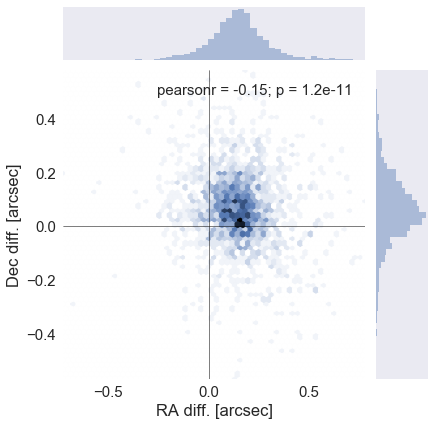

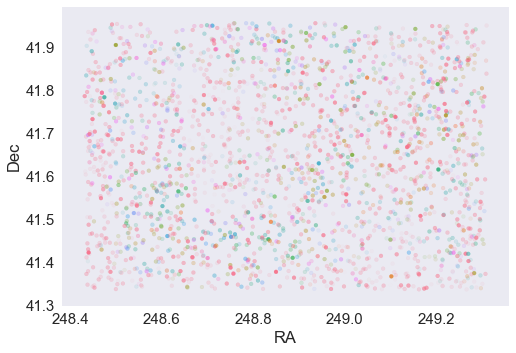

In [29]:
masterlist.nb_astcor_diag_plot(
    wfc['wfc_ra'], wfc['wfc_dec'], gaia_coords.ra, gaia_coords.dec)

In [30]:
wfc_delta_ra, wfc_delta_dec = utils.astrometric_correction(
    SkyCoord(wfc['wfc_ra'], wfc['wfc_dec']),
    gaia_coords
)
wfc['wfc_ra'] += wfc_delta_ra
wfc['wfc_dec'] += wfc_delta_dec

print("WFC delta RA / delta Dec: {} / {}".format(wfc_delta_ra, wfc_delta_dec))

WFC delta RA / delta Dec: 0.1445240357725197 arcsec / 0.0 arcsec


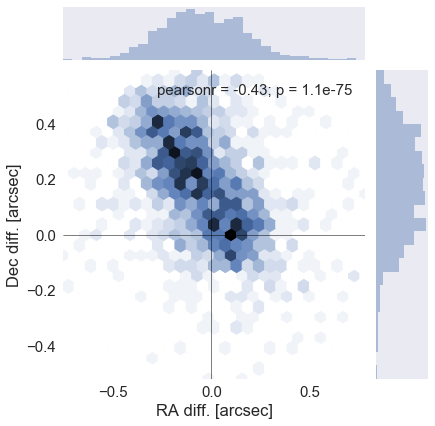

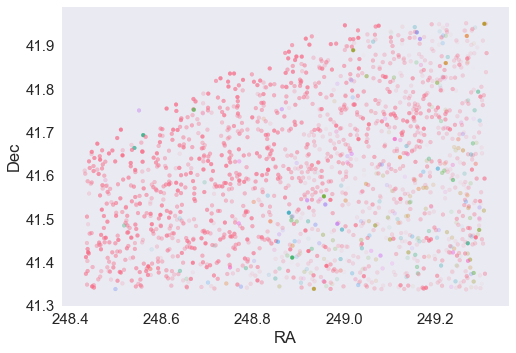

In [31]:
masterlist.nb_astcor_diag_plot(
    swire['swire_ra'], swire['swire_dec'], gaia_coords.ra, gaia_coords.dec)

In [32]:
swire_delta_ra, swire_delta_dec = utils.astrometric_correction(
    SkyCoord(swire['swire_ra'], swire['swire_dec']),
    gaia_coords
)
swire['swire_ra'] += swire_delta_ra
swire['swire_dec'] += swire_delta_dec

print("SWIRE delta RA / delta Dec: {} / {}".format(swire_delta_ra, swire_delta_dec))

SWIRE delta RA / delta Dec: 0.0 arcsec / 0.17901784367211349 arcsec


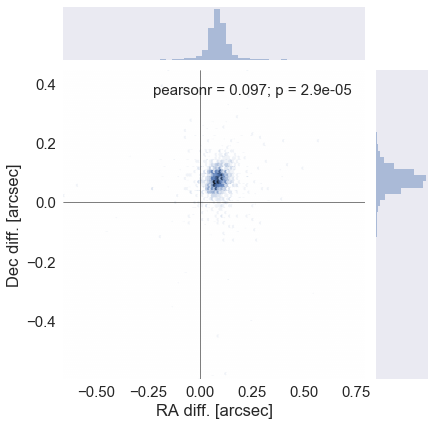

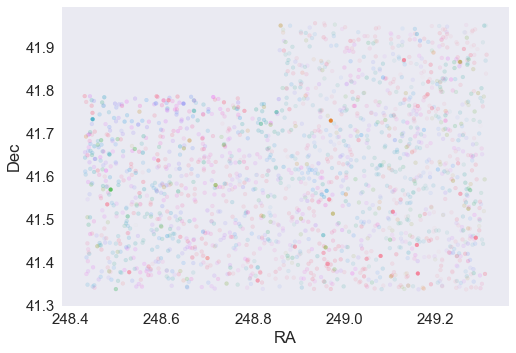

In [33]:
masterlist.nb_astcor_diag_plot(
    sparcs['sparcs_ra'], sparcs['sparcs_dec'], gaia_coords.ra, gaia_coords.dec)

In [34]:
sparcs_delta_ra, sparcs_delta_dec = utils.astrometric_correction(
    SkyCoord(sparcs['sparcs_ra'], sparcs['sparcs_dec']),
    gaia_coords
)
sparcs['sparcs_ra'] += sparcs_delta_ra
sparcs['sparcs_dec'] += sparcs_delta_dec

print("SpARCS delta RA / delta Dec: {} / {}".format(sparcs_delta_ra, sparcs_delta_dec))

SpARCS delta RA / delta Dec: 0.0 arcsec / 0.0 arcsec


## IV - Flagging Gaia objects

In [35]:
wfc.add_column(
    flagging.gaia_flag_column(
        SkyCoord(wfc['wfc_ra'], wfc['wfc_dec']),
        wfc_epoch,
        gaia
    )
)
wfc['flag_gaia'].name = 'wfc_flag_gaia'
print("{} sources flagged.".format(np.sum(wfc['wfc_flag_gaia'] > 0)))

244 sources flagged.


In [36]:
swire.add_column(
    flagging.gaia_flag_column(
        SkyCoord(swire['swire_ra'], swire['swire_dec']),
        swire_epoch,
        gaia
    )
)
swire['flag_gaia'].name = 'swire_flag_gaia'
print("{} sources flagged.".format(np.sum(swire['swire_flag_gaia'] > 0)))

112 sources flagged.


In [37]:
sparcs.add_column(
    flagging.gaia_flag_column(
        SkyCoord(sparcs['sparcs_ra'], sparcs['sparcs_dec']),
        sparcs_epoch,
        gaia
    )
)
sparcs['flag_gaia'].name = 'sparcs_flag_gaia'
print("{} sources flagged.".format(np.sum(sparcs['sparcs_flag_gaia'] > 0)))

1918 sources flagged.


## IV - Flagging objects near bright stars

## V- Merging the catalogues

In [38]:
wfc['wfc_ra'].name = 'ra'
wfc['wfc_dec'].name = 'dec'
masterlist_catalogue = masterlist.merge_catalogues(
    wfc, swire, "swire_ra", "swire_dec")
masterlist_catalogue = masterlist.merge_catalogues(
    masterlist_catalogue, sparcs, "sparcs_ra", "sparcs_dec")

In [39]:
# When we merge the catalogues, astropy masks the non-existent values (e.g. when a row comes
# only from a catalogue and has no counterparts in the other, the columns from the latest
# are masked for that row). We indicate to use NaN for masked values for floats columns and
# False for flag columns.
for col in masterlist_catalogue.colnames:
    if "m_" in col or "merr_" in col or "f_" in col or "ferr_" in col or "stellarity" in col:
        masterlist_catalogue[col].fill_value = np.nan
    elif "flag" in col:
        masterlist_catalogue[col].fill_value = False

In [40]:
masterlist_catalogue[:10].show_in_notebook()

idx,wfc_id,ra,dec,wfc_stellarity,m_app_wfc_u,merr_app_wfc_u,m_wfc_u,merr_wfc_u,m_app_wfc_g,merr_app_wfc_g,m_wfc_g,merr_wfc_g,m_app_wfc_r,merr_app_wfc_r,m_wfc_r,merr_wfc_r,m_app_wfc_i,merr_app_wfc_i,m_wfc_i,merr_wfc_i,m_app_wfc_z,merr_app_wfc_z,m_wfc_z,merr_wfc_z,f_app_wfc_u,ferr_app_wfc_u,flag_app_wfc_u,f_wfc_u,ferr_wfc_u,flag_wfc_u,f_app_wfc_g,ferr_app_wfc_g,flag_app_wfc_g,f_wfc_g,ferr_wfc_g,flag_wfc_g,f_app_wfc_r,ferr_app_wfc_r,flag_app_wfc_r,f_wfc_r,ferr_wfc_r,flag_wfc_r,f_app_wfc_i,ferr_app_wfc_i,flag_app_wfc_i,f_wfc_i,ferr_wfc_i,flag_wfc_i,f_app_wfc_z,ferr_app_wfc_z,flag_app_wfc_z,f_wfc_z,ferr_wfc_z,flag_wfc_z,wfc_flag_cleaned,wfc_flag_gaia,flag_merged,swire_intid,f_app_swire_irac1,ferr_app_swire_irac1,f_swire_irac1,ferr_swire_irac1,swire_stellarity_irac1,f_app_swire_irac2,ferr_app_swire_irac2,f_swire_irac2,ferr_swire_irac2,swire_stellarity_irac2,f_app_swire_irac3,ferr_app_swire_irac3,f_swire_irac3,ferr_swire_irac3,swire_stellarity_irac3,f_app_swire_irac4,ferr_app_swire_irac4,f_swire_irac4,ferr_swire_irac4,swire_stellarity_irac4,m_app_swire_irac1,merr_app_swire_irac1,flag_app_swire_irac1,m_swire_irac1,merr_swire_irac1,flag_swire_irac1,m_app_swire_irac2,merr_app_swire_irac2,flag_app_swire_irac2,m_swire_irac2,merr_swire_irac2,flag_swire_irac2,m_app_swire_irac3,merr_app_swire_irac3,flag_app_swire_irac3,m_swire_irac3,merr_swire_irac3,flag_swire_irac3,m_app_swire_irac4,merr_app_swire_irac4,flag_app_swire_irac4,m_swire_irac4,merr_swire_irac4,flag_swire_irac4,swire_flag_cleaned,swire_flag_gaia,sparcs_intid,sparcs_stellarity,m_app_cfht_megacam_u,merr_app_cfht_megacam_u,f_app_cfht_megacam_u,ferr_app_cfht_megacam_u,m_cfht_megacam_u,merr_cfht_megacam_u,f_cfht_megacam_u,ferr_cfht_megacam_u,flag_cfht_megacam_u,m_app_cfht_megacam_g,merr_app_cfht_megacam_g,f_app_cfht_megacam_g,ferr_app_cfht_megacam_g,m_cfht_megacam_g,merr_cfht_megacam_g,f_cfht_megacam_g,ferr_cfht_megacam_g,flag_cfht_megacam_g,m_app_cfht_megacam_r,merr_app_cfht_megacam_r,f_app_cfht_megacam_r,ferr_app_cfht_megacam_r,m_cfht_megacam_r,merr_cfht_megacam_r,f_cfht_megacam_r,ferr_cfht_megacam_r,flag_cfht_megacam_r,m_app_cfht_megacam_z,merr_app_cfht_megacam_z,f_app_cfht_megacam_z,ferr_app_cfht_megacam_z,m_cfht_megacam_z,merr_cfht_megacam_z,f_cfht_megacam_z,ferr_cfht_megacam_z,flag_cfht_megacam_z,sparcs_flag_cleaned,sparcs_flag_gaia
,,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mag,mag,,,,,,,,mag,mag,,,,,,,,mag,mag,,,,,,,,mag,mag,,,,,
0,302159103014,249.029415936,41.496058307,0.49923,0.0,0.0,23.232,0.24,0.0,0.0,20.521,0.035,0.0,0.0,19.489,0.029,nan,nan,nan,nan,20.302,0.061,19.715,0.085,3.63078e+09,0.0,False,1.85012,0.408965,False,3.63078e+09,0.0,False,22.4698,0.72434158028,False,3.63078e+09,0.0,False,58.1299,1.55264880232,False,nan,nan,False,nan,nan,False,27.4916,1.54456236305,False,47.2063,3.69568,False,False,0,False,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,False,--,--,False,--,--,False,--,--,False,--,--,False,--,--,False,--,--,False,--,--,False,False,0,--,--,--,--,--,--,--,--,--,--,False,--,--,--,--,--,--,--,--,False,--,--,--,--,--,--,--,--,False,--,--,--,--,--,--,--,--,False,False,0
1,219810202696,248.775800789,41.76330066,0.0030764,nan,nan,nan,nan,0.0,0.0,21.984,0.084,0.0,0.0,21.349,0.07,0.0,0.0,19.655,0.04,0.0,0.0,19.446,0.081,nan,nan,False,nan,nan,False,3.63078e+09,0.0,False,5.83983,0.45180944835,False,3.63078e+09,0.0,False,10.4809,0.67573013439,False,3.63078e+09,0.0,False,49.8884,1.83795622434,False,3.63078e+09,0.0,False,60.4784,4.51191,False,False,0,False,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,False,--,--,False,--,--,False,--,--,False,--,--,False,--,--,False,--,--,False,--,--,False,False,0,--,--,--,--,--,--,--,--,--,--,False,--,--,--,--,--,--,--,--,False,--,--,--,--,--,--,--,--,False,--,--,--,--,--,--,--,--,False,False,0
2,302159402793,248.977728692,41.612435196,0.996753,nan,nan,nan,nan,0.0,0.0,20.618,0.037,0.0,0.0,19.077,0.028,19.68,0.024,18.63

## VI - Merging flags and stellarity

In [41]:
masterlist_catalogue.add_column(Column(
    data=(masterlist_catalogue['wfc_flag_cleaned'] | 
          masterlist_catalogue['swire_flag_cleaned'] |
          masterlist_catalogue['sparcs_flag_cleaned']),
    name="flag_cleaned"
))
masterlist_catalogue.remove_columns(['wfc_flag_cleaned', 
                                     'swire_flag_cleaned',
                                     'sparcs_flag_cleaned'])

In [42]:
masterlist_catalogue.add_column(Column(
    data=(masterlist_catalogue['wfc_flag_gaia'] | 
          masterlist_catalogue['swire_flag_gaia'] |
          masterlist_catalogue['sparcs_flag_gaia']),
    name="flag_gaia"
))
masterlist_catalogue.remove_columns(['wfc_flag_gaia', 
                                     'swire_flag_gaia',
                                     'sparcs_flag_gaia'])

In [43]:
masterlist_catalogue.add_column(Column(
    data=np.nanmax([masterlist_catalogue['wfc_stellarity'],
                     masterlist_catalogue['swire_stellarity_irac1'],
                     masterlist_catalogue['swire_stellarity_irac2'],
                     masterlist_catalogue['swire_stellarity_irac3'],
                     masterlist_catalogue['swire_stellarity_irac4'],
                     masterlist_catalogue['sparcs_stellarity']],
                   axis=0),
    name='stellarity'
))
masterlist_catalogue.remove_columns(
    ['wfc_stellarity',
     'swire_stellarity_irac1',
     'swire_stellarity_irac2',
     'swire_stellarity_irac3',
     'swire_stellarity_irac4',
     'sparcs_stellarity']
)

## VII - E(B-V)

In [45]:
masterlist_catalogue.add_column(
    utils.ebv(masterlist_catalogue['ra'], masterlist_catalogue['dec'])
)

## VIII - Choosing between multiple values for the same filter

We have IRAC1 and IRAC2 observation for both SERVS and SWIRE.  We must choose which one to use, remove the unused columns, and rename the ones we keep to names like `f_irac1`...

## IX - Number of bands with observation

In [46]:
# We consider that a source is observed in a band when both the aperture and the full
# magnitudes are provided (some buggy catalogues miss some).

nb_bands = np.zeros(len(masterlist_catalogue), dtype=int)
for col in masterlist_catalogue.colnames:
    if 'm_app_' in col:
        fullmag_col = col.replace('m_app_', 'm_')
        nb_bands += (
            ~np.isnan(masterlist_catalogue[col].filled())
            & ~np.isnan(masterlist_catalogue[fullmag_col].filled())
        )

masterlist_catalogue.add_column(Column(data=nb_bands, name="nb_optnir_bands"))

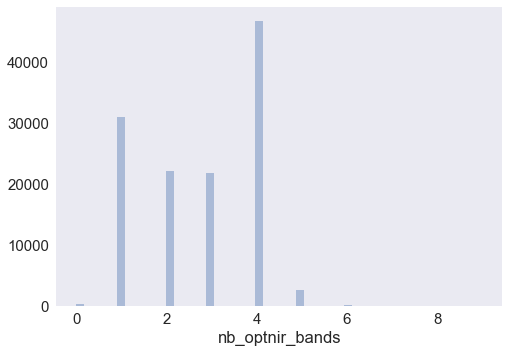

In [47]:
sns.distplot(masterlist_catalogue['nb_optnir_bands'], kde=False)

## X - Adding the HELP Id and field columns

In [48]:
masterlist_catalogue.add_column(Column(
    utils.gen_help_id(masterlist_catalogue['ra'], masterlist_catalogue['dec']),
    name="help_id"
))
masterlist_catalogue.add_column(Column(
    np.full(len(masterlist_catalogue), "ELAIS-N1", dtype='<U18'),
    name="field"
))

In [49]:
# Check that the HELP Ids are unique
if len(masterlist_catalogue) != len(np.unique(masterlist_catalogue['help_id'])):
    print("The HELP IDs are not unique!!!")
else:
    print("OK!")

OK!


## XI - Cross-identification table

We are producing a table associating to each HELP identifier, the identifiers of the sources in the pristine catalogue. This can be used to easily get additional information from them.

In [51]:
cross_ident_table = masterlist_catalogue[
    'help_id', 'wfc_id', 'swire_intid', 'sparcs_intid']
cross_ident_table.write("data/master_list_cross_ident_elais-n2.fits")

## XII - Cleaning and saving the master catalogue

In [52]:
masterlist_catalogue.remove_columns([
    'wfc_id', 'swire_intid', 'sparcs_intid'])

In [47]:
# We may want to reorder the column even if this will be done at the ingestion in HeDaM.

In [53]:
masterlist_catalogue.write("data/master_catalogue_elais-n2.fits")